In [1]:
from __future__ import division
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

import pos_stocks

%matplotlib inline

# Customer buying sims

We simplify the model for customers buy SIMS by assuming all customers buy a sim every `sim_buy_mean_period_days` days => the number of SIM bought every day is

$$
    n = \frac{\text{n_customers}}{\text{sim_buy_mean_period_days}}
$$

And because we have `n_pos` point of sales, each POS has a probability `p` of being chosen: 

$$
    p = \frac{1}{\text{n_pos}}
$$

Based on that we can build the stock level transition matrix corresponding to those SIM purchases with: 

$$
\begin{split}
    P(s, s-k) & = \text{Binom}(k | n, p)\ \ \text{for k} \in [0, n] \\
              & = 0 \ \ \text{for k} < 0\ \ \text{or}\ k > n
\end{split}
$$

The implementation below is slightly different since it prevents stock to go below 0, i.e. not all $s-k$ values are allowed. 

In [2]:
def sim_delta_pmf_up_to(max_delta, p_delta):
    """
    Return a pmf of size max_delta + 1 containing the probability of 
    of all stock decrement sizes for size ranging from 0 to max_delta.
    
    This simply encapsulate the fact a stock cannot go to negative values
    """
    
    pmf = np.array([p_delta(k) for k in range(max_delta+1)])
    
    # All the binomial values corresponding to impossible stock decrease simply pile
    # up as a full out of stock situation (we're not modelling customer re-trying by going to other shops...)
    pmf[-1] += 1 - pmf.sum()
    
    # fixing small rounding errors
    for idx, val in enumerate(pmf):
        if val < 0 and val > -1e-10:
            pmf[idx] = 0
        if val > 1 and val < 1 + 1e-10:
            pmf[idx] = 1
            
    return pmf
    
def customer_transition_matrix(params):
    
    T_size =  params["max_stock"] + 1    
    
    n = params["n_customers"]/params["sim_buy_mean_period_days"]
    p = 1/params["n_pos"]

    print ("Stock decrease due to customer buying SIMs should follow a Binomial({}, {})".format(n, p))
    p_delta = pos_stocks.binom_pmf(n, p )
    

    return np.array(
            [pos_stocks.post_pad(sim_delta_pmf_up_to(i, p_delta)[::-1], target_size=T_size) 
                 for i in range(T_size)
            ]
        ).T


`customer_transition_matrix` returns a left multiplying matrix modeling the stock level transitions due to customer buying SIM, i.e. $T_{cust}x(t) = x(t+1)$. It seems many Markov chain documentations put $T_{cust}$ as a right multiplying matrix, though I find it counter-intuitive based on the linear system conventions.

 => "from stock" is on top and "to stock" is on the side.

Stock level are modeled as their corresponding index in the matrix

 => $T_{cust}(10,15)$ corresponds to the probability to transit from stock=15 to stock=12 in one day.
 
Said otherwise, $T_{cust}$ models $P^T$ discribed in the text above. 


# POS bulk purchases


POS buying bulks of SIM to upstream dealers are parameterized with the random variable B modelling the distribution of bulk sizes and T the distribution of periods between purchases. Those two are modeled as independent for the moment.

The transition matrix only allows $P(s, s+k)$ for $k \in B$ or $k = 0$ since these are the only stock variation allowed by this model: POS cannot buy several SIM bulks on the same day. 

We have: 

$$
\begin{split}
P(s, s+b) & = P(B=b) \sum\limits_{t \in T}\frac{P(T=t | B=b)}{t}\   \forall b \in B  \\
          & = 1 - \sum\limits_{b \in B}P(B=b) \sum\limits_{t \in T}\frac{P(T=t | B=b)}{t} \ \text{ for } b = 0\\
          & = 0 \text{ elsewhere}
\end{split}
$$



In [3]:
def bulk_delta_pseudo_pmf_up_to(bulk_size_distro, bulk_periods_distro, max_delta):
        
    max_bulk_size = max(bulk_size_distro.keys())
    pseudo_pmf = np.array([0.] * max(max_delta+1, max_bulk_size+1))    
    
    for delta in bulk_size_distro.keys():        
        for period in bulk_periods_distro.keys():                                
            pseudo_pmf[delta] += bulk_periods_distro[period] * bulk_size_distro[delta]/period
    
    # first "real" normalization: anything not happening pile up as probability of not
    # changing the stock
    pseudo_pmf[0] = 1 - pseudo_pmf.sum()
    
    # truncating to avoid too large stocks
    pseudo_pmf = pseudo_pmf[:max_delta+1] 
    
    # normalizing again, this time piling up any "overflow" action to "out of stock", i.e. max_delta
    pseudo_pmf[-1] += 1 - pseudo_pmf.sum()
    
    return pseudo_pmf

def bulk_transition_matrix(params):
    

    T_size = params["max_stock"] + 1  

    # stock daily transition matrix due to pos buying bulks of sims

    return np.array(
            [pos_stocks.post_pad(
                pos_stocks.pre_pad(
                    bulk_delta_pseudo_pmf_up_to(params["bulk_size_distro"], 
                                                params["bulk_periods_distro"],
                                                max_delta=T_size-i-1), 
                    n_pads=i),
                target_size=T_size) 
             for i in range(T_size)]
        ).T
    


# Putting it all together

In [4]:

def show_convergence(params):
    
    e_sim = params["n_customers"]/(params["sim_buy_mean_period_days"]*params["n_pos"])

    print """
    for each pos:
        - expected number of daily sim sold: {}
        - expected number of daily sim bought: {}
    """.format(e_sim, 
           pos_stocks.ev( params["bulk_size_distro"])/pos_stocks.ev( params["bulk_periods_distro"]))
    
    
    T_cust = customer_transition_matrix(params)
    T_bulk = bulk_transition_matrix(params)

    # the order of the multiplication should in principle not matter too much in this case
    # though the border effects due to max stock and out-of-stock seem prefereable in the 
    # first version below
    T = T_cust.dot(T_bulk) 
    T_alt = T_bulk.dot(T_cust) 
    
    # plotting transition matrices
    fig, ax = plt.subplots(2,2, figsize=(9, 8))
    
    pos_stocks.build_heatmap(T_cust, ax=ax[0,0])
    ax[0,0].set_title("cust transition matrix")

    pos_stocks.build_heatmap(T_bulk, ax=ax[0,1])
    ax[0,1].set_title("bulk transition matrix")
    
    pos_stocks.build_heatmap(T, ax=ax[1,0])
    ax[1,0].set_title("resulting transition matrix")

    pos_stocks.build_heatmap(T_alt, ax=ax[1,1])
    ax[1,1].set_title("alternative resulting transition matrix (not used)")
    
    plt.show()
    
    
    # plotting the convergence of transition matrix by applying tons of times
    tn = T
    rows = 5
    cols = 5

    fig, ax = plt.subplots(rows,cols, figsize=(15, rows*2.7 ))

    for r in range(rows):
        for c in range(cols):
            pos_stocks.build_heatmap(tn, ax=ax[r, c]);
            ax[r, c].set_title("T**{}".format(2**(r+1)*(c+1)))
            tn = tn.dot(tn)

    plt.show()
    
    
    # looking for the stationary distribution analytically
    
    stat_dist, res = pos_stocks.compute_stationary(T)
    pd.Series(stat_dist).plot(
        title="resulting stationary distribution (solution residuals: {})".format(res)
    );

# Some results

## Balanced


    for each pos:
        - expected number of daily sim sold: 5.0
        - expected number of daily sim bought: 4.11764705882
    
Stock decrease due to customer buying SIMs should follow a Binomial(50.0, 0.1)


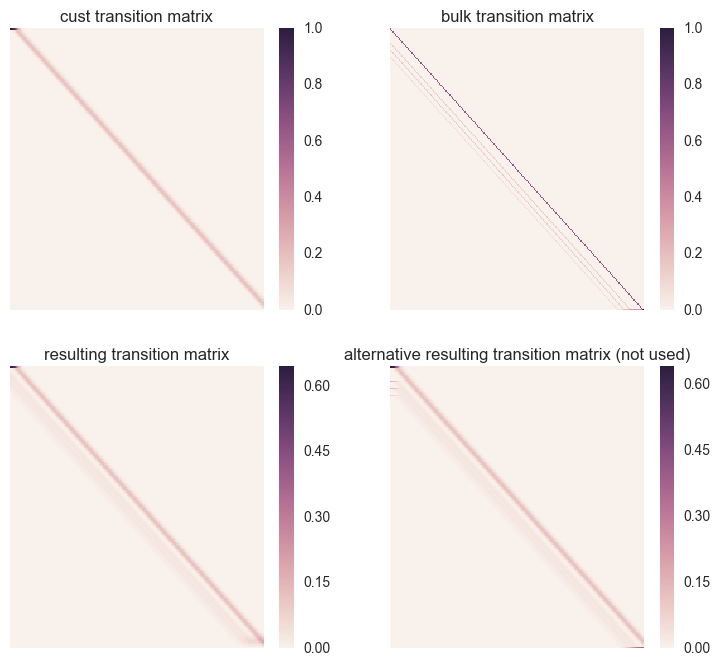

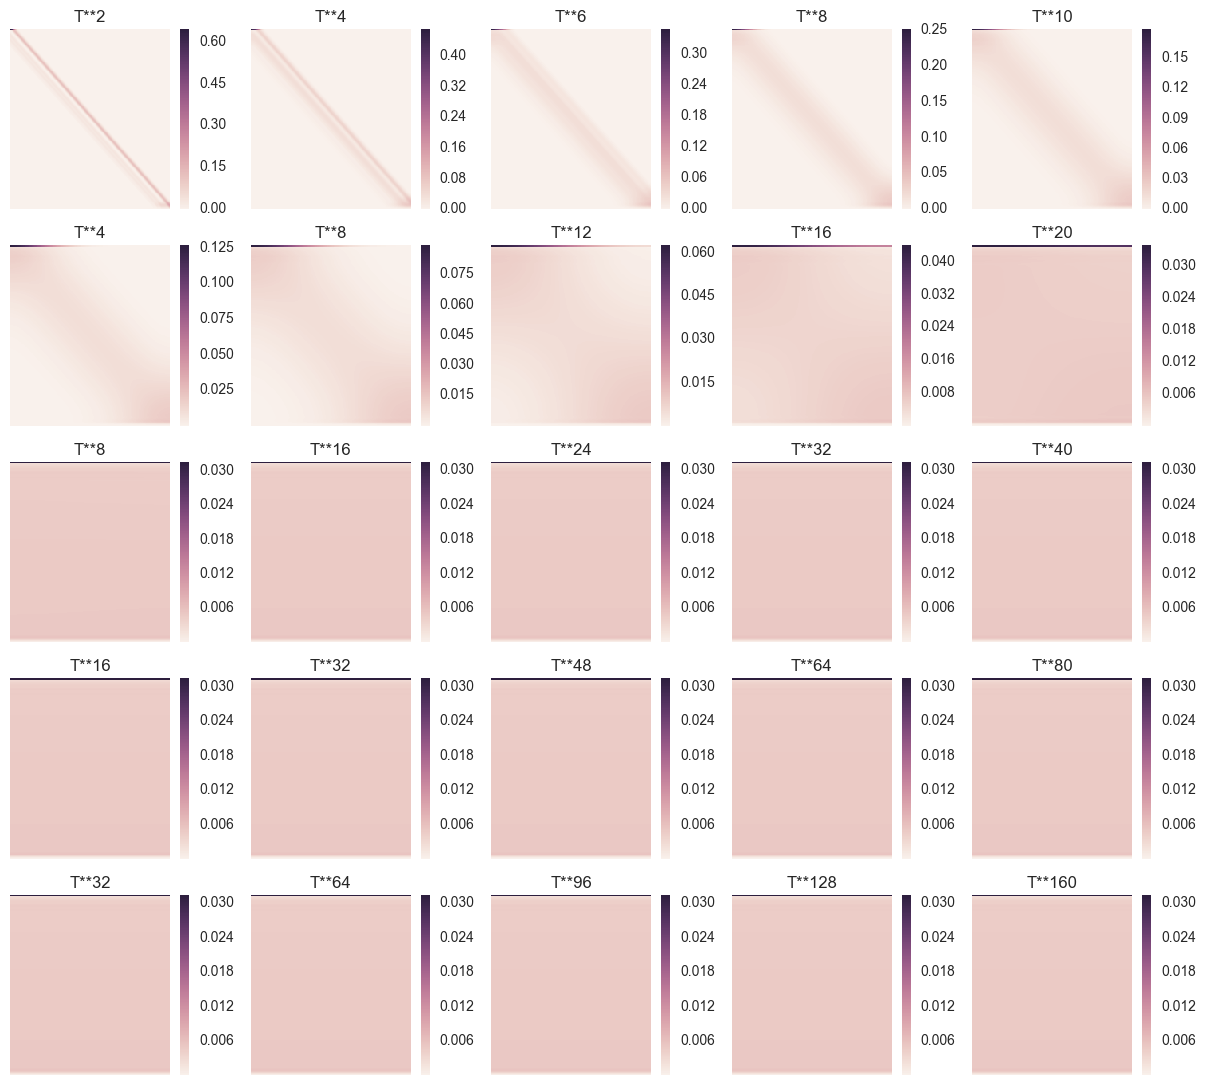

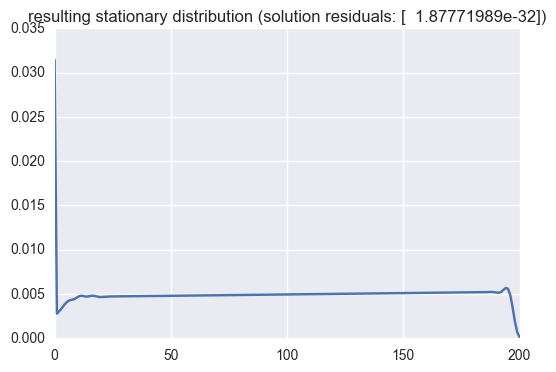

In [5]:
params_balanced = {
    
    "max_stock": 200,

    "n_customers": 500,
    "sim_buy_mean_period_days": 10,
    "n_pos": 10,


    # distribution of the purchased sim bulk sizes
    # this should normally be much smaller than max_stock 
    "bulk_size_distro" :{
       10: .4,
       15: .4,
       20: .2
    },

    # distribution of the bulk purchase periods
    "bulk_periods_distro": {

       # don't put period=0 here... 

       2: .50,
       4: .3,
       6: .2
    }
}

show_convergence(params_balanced)    

## Too few customers purchases


    for each pos:
        - expected number of daily sim sold: 2.0
        - expected number of daily sim bought: 4.11764705882
    
Stock decrease due to customer buying SIMs should follow a Binomial(20.0, 0.1)


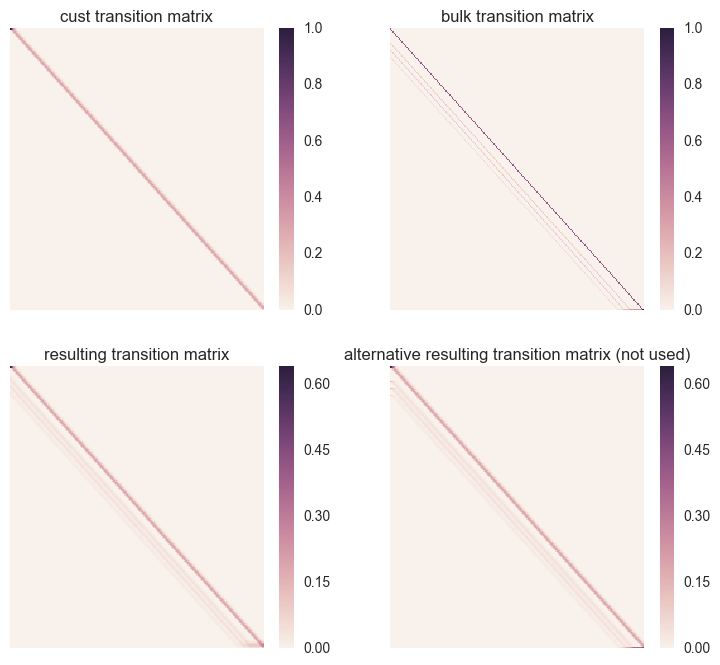

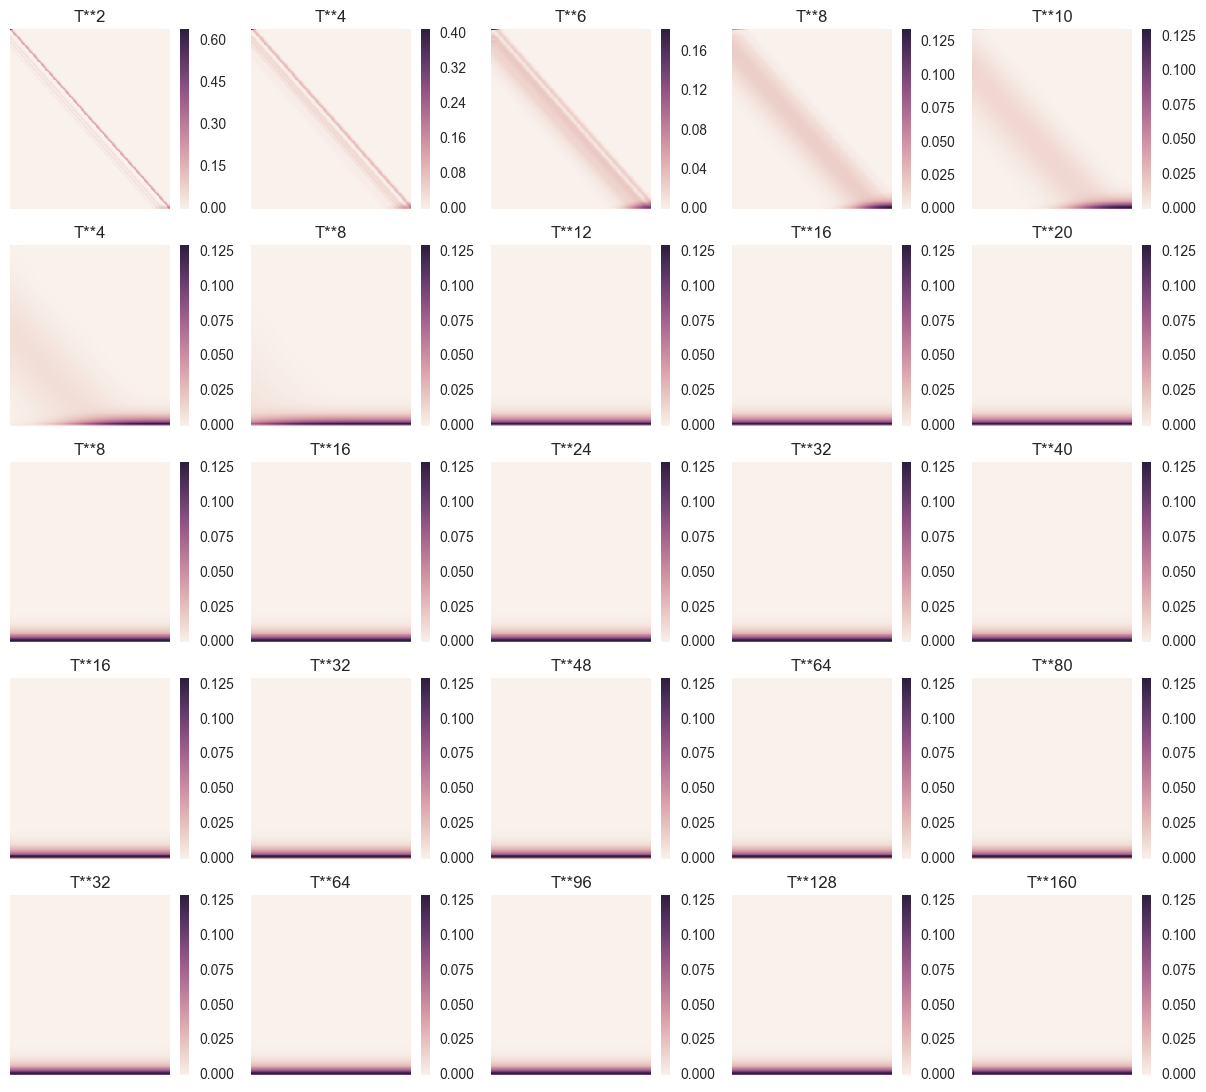

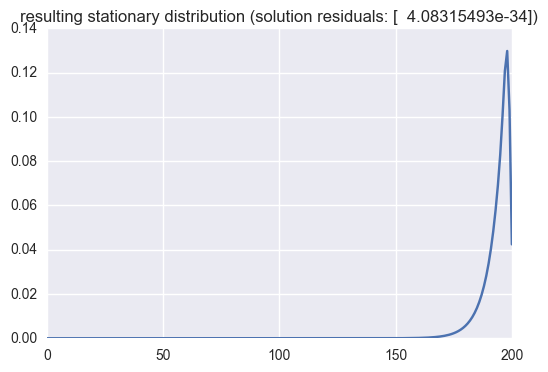

In [6]:
params_to_max_stock = {
    
    "max_stock": 200,

    "n_customers": 200,
    "sim_buy_mean_period_days": 10,
    "n_pos": 10,


    # distribution of the purchased sim bulk sizes
    # this should normally be much smaller than max_stock 
    "bulk_size_distro" :{
       10: .4,
       15: .4,
       20: .2
    },

    # distribution of the bulk purchase periods
    "bulk_periods_distro": {

       # don't put period=0 here... 

       2: .50,
       4: .3,
       6: .2
    }
}

show_convergence(params_to_max_stock)    

## Too many customer purchases


    for each pos:
        - expected number of daily sim sold: 7.0
        - expected number of daily sim bought: 4.11764705882
    
Stock decrease due to customer buying SIMs should follow a Binomial(70.0, 0.1)


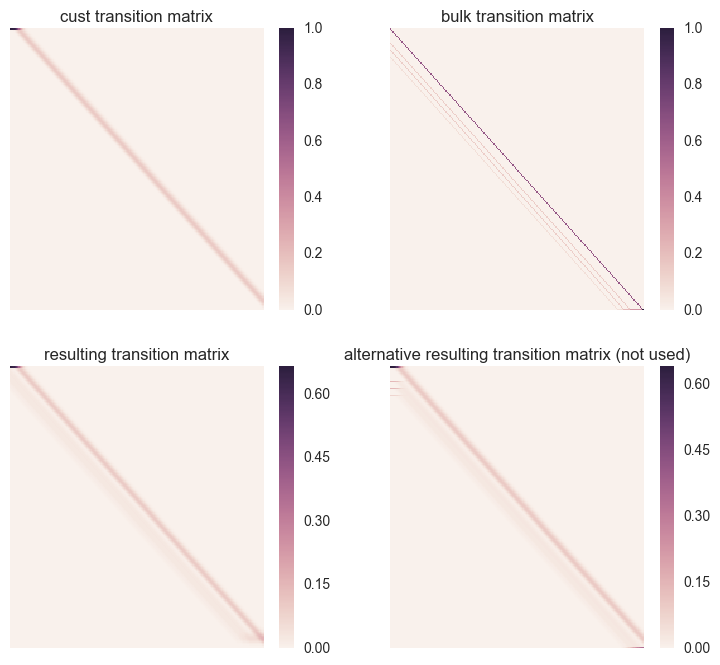

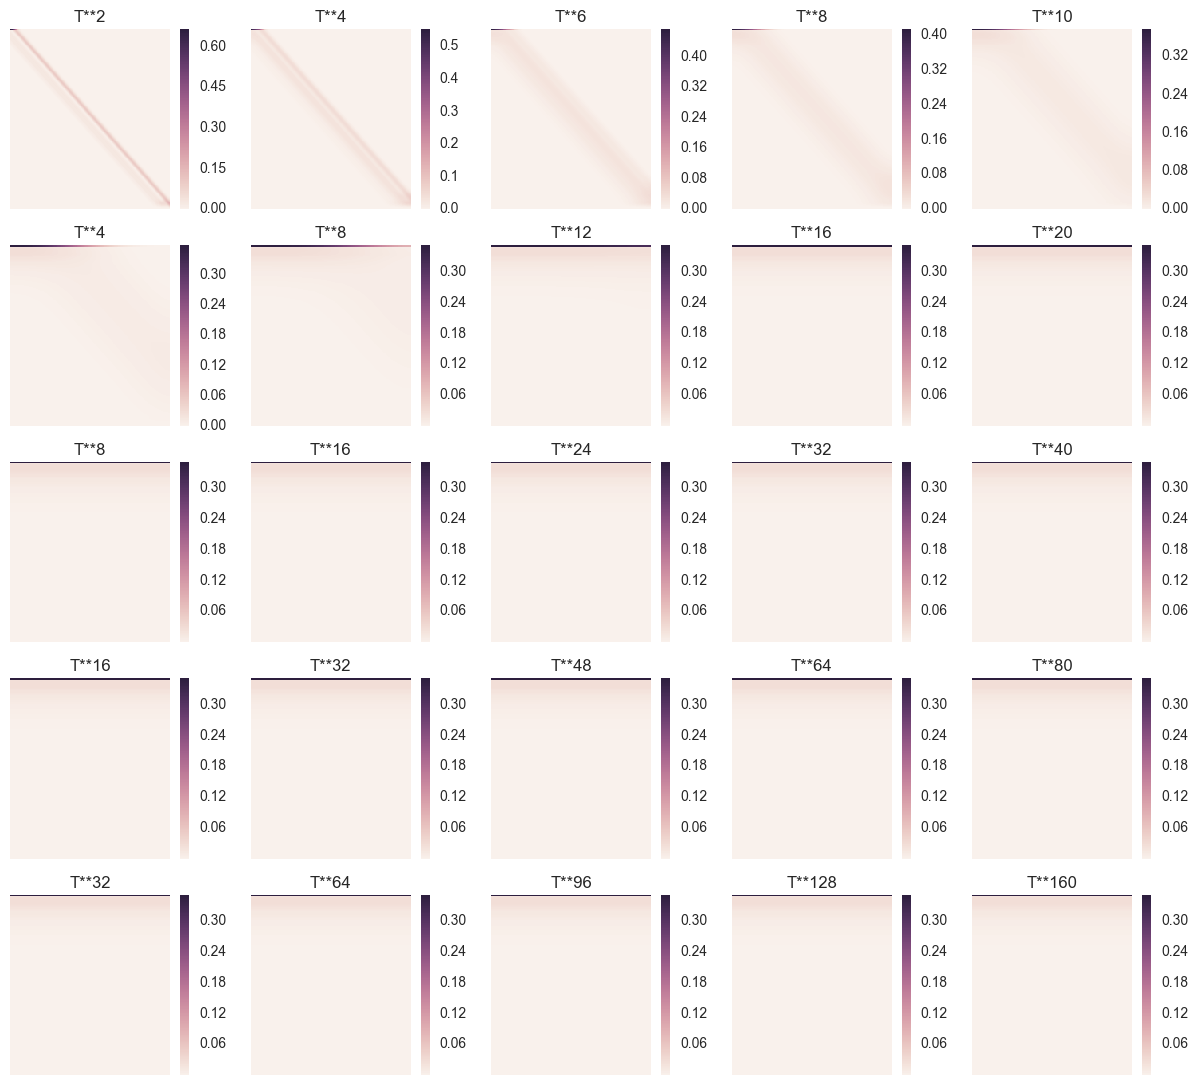

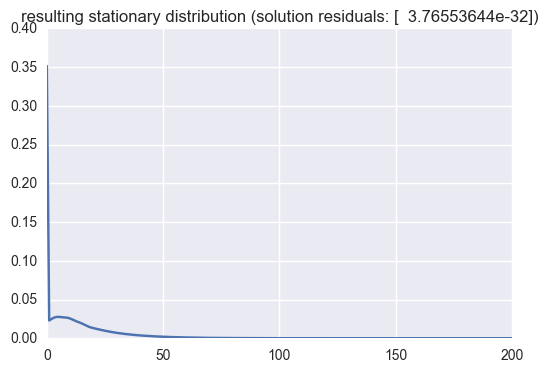

In [7]:
params_to_out_of_stock = {
    
    "max_stock": 200,

    "n_customers": 700,
    "sim_buy_mean_period_days": 10,
    "n_pos": 10,


    # distribution of the purchased sim bulk sizes
    # this should normally be much smaller than max_stock 
    "bulk_size_distro" :{
       10: .4,
       15: .4,
       20: .2
    },

    # distribution of the bulk purchase periods
    "bulk_periods_distro": {

       # don't put period=0 here... 

       2: .50,
       4: .3,
       6: .2
    }
}

show_convergence(params_to_out_of_stock)    